In [2]:
from neurotask.tmt.tmt_analyzer import TMTAnalyzer

from src import config
from src.hand_analysis.mapper.psychopy_mapper import PsychopyTMTMapper

analyzer = TMTAnalyzer(
    mapper=PsychopyTMTMapper(),
    dataset_path=config.PYXATIONS_PATIENTS_DATA_DIR,
    output_path=config.DATA_DIR
)
#analysis = run_analysis_with_configuration_parameters(config.DATA_DIR)
experiment = analyzer.get_experiment()

In [3]:
subject = experiment.subjects["0063"]
subject

TMTSubject(training_trials=[], testing_trials=[TMTTrial(stimuli=[TMTTarget(content='1', position=Coordinate(x=-0.20191733333333317, y=-0.2820346666666667)), TMTTarget(content='2', position=Coordinate(x=-0.1183973333333332, y=-0.3655546666666667)), TMTTarget(content='3', position=Coordinate(x=-0.14623733333333336, y=-0.1706746666666666)), TMTTarget(content='4', position=Coordinate(x=-0.25759733333333334, y=-0.11499466666666662)), TMTTarget(content='5', position=Coordinate(x=-0.007037333333333234, y=-0.1706746666666666)), TMTTarget(content='6', position=Coordinate(x=0.16000266666666654, y=-0.11499466666666662)), TMTTarget(content='7', position=Coordinate(x=0.2435226666666667, y=0.13556533333333332)), TMTTarget(content='8', position=Coordinate(x=0.38272266666666666, y=0.24692533333333327)), TMTTarget(content='9', position=Coordinate(x=0.2713626666666667, y=-0.059314666666666634)), TMTTarget(content='10', position=Coordinate(x=0.41056266666666663, y=0.1634053333333333)), TMTTarget(content=

In [4]:

from neurotask.tmt.model.tmt_model import TMTTrial


def plot_with_color(trial: TMTTrial, canvas_size: int, target_radius: float, color_by='time'):
    """
    Plotea la trayectoria del cursor junto con los targets en un gráfico,
    ajustando el tamaño del gráfico al tamaño del canvas y dibujando círculos
    alrededor de los targets con su contenido. La trayectoria del cursor se
    dibuja con puntos cuyos colores cambian en función del tiempo, la velocidad o la aceleración.
    El primer clic en el target se destaca con un marcador especial.

    Parameters:
    - trial: TMTTrial, el trial con la trayectoria del cursor y los targets.
    - canvas_size: int, tamaño del canvas (ancho y alto).
    - target_radius: float, radio de los círculos que rodean los targets.
    - color_by: str, 'time', 'speed' o 'acceleration', determina si el color de los puntos cambia en función del tiempo, velocidad o aceleración.
    """

    # Extraer la posición de los targets
    target_x = [target.position.x for target in trial.stimuli]
    target_y = [target.position.y for target in trial.stimuli]
    target_contents = [target.content for target in trial.stimuli]

    cursor_trail_from_first_click = trial.cursor_trail  #.get_cursor_trail_from_start()
    # Extraer la trayectoria del cursor
    cursor_x = [cursor_info.position.x for cursor_info in cursor_trail_from_first_click]
    cursor_y = [cursor_info.position.y for cursor_info in cursor_trail_from_first_click]
    cursor_times = [cursor_info.time for cursor_info in cursor_trail_from_first_click]

    if color_by == 'time':
        # Normalizar tiempos para que estén en el rango [0, 1]
        norm = plt.Normalize(min(cursor_times), max(cursor_times))
        colors = plt.cm.viridis(norm(cursor_times))  # Usar un mapa de colores para el tiempo
    elif color_by == 'speed':
        speeds = calculate_speeds_between_cursor_positions(trial)
        speeds = [0] + speeds  # Para igualar el número de puntos con las velocidades calculadas
        norm = plt.Normalize(min(speeds), max(speeds))
        colors = plt.cm.viridis(norm(speeds))  # Usar un mapa de colores para la velocidad
    elif color_by == 'acceleration':
        accelerations = calculate_accelerations_between_cursor_positions(trial)
        accelerations = [0, 0] + accelerations  # Igualar el número de puntos (2 primeros puntos sin aceleración)
        norm = plt.Normalize(min(accelerations), max(accelerations))
        colors = plt.cm.viridis(norm(accelerations))  # Usar un mapa de colores para la aceleración
    else:
        raise ValueError("El parámetro color_by debe ser 'time', 'speed' o 'acceleration'.")

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(8, 8))

    # Dibujar la trayectoria del cursor como líneas coloreadas por tiempo o velocidad
    for i in range(len(cursor_x) - 1):
        plt.plot([cursor_x[i], cursor_x[i + 1]],
                 [cursor_y[i], cursor_y[i + 1]],
                 color=colors[i], linewidth=2, zorder=4)

    # Dibujar los targets como círculos con el contenido dentro
    for x, y, content in zip(target_x, target_y, target_contents):
        circle = plt.Circle((x, y), target_radius, color='red', alpha=0.3, zorder=5)
        plt.gca().add_patch(circle)
        # Añadir el contenido del target en el centro del círculo
        plt.text(x, y, content, color='black', fontsize=8, ha='center', va='center', zorder=6)

    # Destacar el primer clic
    if trial.start:
        fc_x = trial.start.position.x
        fc_y = trial.start.position.y
        plt.scatter(fc_x, fc_y, color='cyan', edgecolor='black', s=100, label='First Click', zorder=7,
                    marker='o', alpha=0.3)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar_label = 'Time' if color_by == 'time' else 'Speed' if color_by == 'speed' else 'Acceleration'
    cbar = fig.colorbar(sm, ax=ax, label=cbar_label)

    # # Set plot limits based on canvas size
    # ax.set_xlim(-canvas_size, canvas_size)
    # ax.set_ylim(canvas_size, -canvas_size,)  # Inverted Y-axis if needed

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Cursor Trail with Targets')

    # Ensure equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Add legend
    ax.legend()

    return fig

In [9]:
from src.hand_analysis.loader.load_last_split import load_last_analysis

train_set, _ = load_last_analysis()
subject_analysis = train_set[train_set['subject_id'] == 63]
subject_analysis['speed_thre']

1160    0.204387
1161    0.204387
1162    0.204387
1163    0.204387
1164    0.204387
1165    0.204387
1166    0.204387
1167    0.204387
1168    0.204387
1169    0.204387
1170    0.204387
1171    0.204387
1172    0.204387
1173    0.204387
1174    0.204387
1175    0.204387
1176    0.204387
1177    0.204387
1178    0.204387
1179    0.204387
Name: speed_threshold, dtype: float64

In [7]:

from neurotask.tmt.metrics.speed_metrics import calculate_accelerations_between_cursor_positions
from neurotask.tmt.metrics.speed_metrics import calculate_speeds_between_cursor_positions
from neurotask.tmt.model.tmt_model import TMTTrial

import matplotlib.pyplot as plt


def plot_with_labels(trial: TMTTrial, target_radius: float, labels: list[str]):
    """
    Dibuja la trayectoria del cursor de un trial del TMT, coloreando cada segmento
    según una etiqueta categórica (ej: "TRAVEL", "SEARCH", etc.).

    Parameters:
    - trial: TMTTrial, contiene los targets y la trayectoria del cursor.
    - target_radius: float, radio de los círculos que rodean los targets.
    - labels: list[str], una etiqueta por punto de la trayectoria del cursor.
    """

    # Validar que la cantidad de etiquetas coincida con los puntos de la trayectoria
    cursor_trail = trial.get_cursor_trail_from_start()
    if len(labels) != len(cursor_trail):
        raise ValueError(
            "La cantidad de etiquetas debe coincidir con la cantidad de puntos en la trayectoria del cursor.")

    # Extraer posiciones de los targets
    target_x = [target.position.x for target in trial.stimuli]
    target_y = [target.position.y for target in trial.stimuli]
    target_contents = [target.content for target in trial.stimuli]

    # Extraer posiciones del cursor
    cursor_x = [point.position.x for point in cursor_trail]
    cursor_y = [point.position.y for point in cursor_trail]

    # Generar colores para cada etiqueta única
    unique_labels = list(sorted(set(labels)))
    cmap = plt.get_cmap('tab10') if len(unique_labels) <= 10 else plt.get_cmap('tab20')
    label_to_color = {label: cmap(i % cmap.N) for i, label in enumerate(unique_labels)}

    # Crear figura
    fig, ax = plt.subplots(figsize=(8, 8))

    # Dibujar la trayectoria por tramos, coloreados por etiqueta
    for i in range(len(cursor_x) - 1):
        label = labels[i]
        color = label_to_color[label]
        ax.plot([cursor_x[i], cursor_x[i + 1]],
                [cursor_y[i], cursor_y[i + 1]],
                color=color, linewidth=2, zorder=4)

    # Dibujar targets
    for x, y, content in zip(target_x, target_y, target_contents):
        circle = plt.Circle((x, y), target_radius, color='red', alpha=0.3, zorder=5)
        ax.add_patch(circle)
        ax.text(x, y, content, color='black', fontsize=8, ha='center', va='center', zorder=6)

    # Marcar primer clic
    if trial.start:
        fc_x = trial.start.position.x
        fc_y = trial.start.position.y
        ax.scatter(fc_x, fc_y, color='cyan', edgecolor='black', s=100, label='First Click', zorder=7,
                   marker='o', alpha=0.3)

    # Crear leyenda para etiquetas
    handles = [plt.Line2D([0], [0], color=color, lw=2, label=label) for label, color in label_to_color.items()]
    ax.legend(handles=handles, title="Etiquetas")

    # Estética
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Cursor Trail with Categorical Labels')
    ax.set_aspect('equal', adjustable='box')

    return fig

In [15]:
def plot_with_labels_scatter(trial: TMTTrial, target_radius: float, labels: list[str]):
    """
    Dibuja la trayectoria del cursor de un trial del TMT, coloreando cada punto
    según una etiqueta categórica (ej: "TRAVEL", "SEARCH", etc.) usando scatter.

    Parameters:
    - trial: TMTTrial, contiene los targets y la trayectoria del cursor.
    - target_radius: float, radio de los círculos que rodean los targets.
    - labels: list[str], una etiqueta por punto de la trayectoria del cursor.
    """

    # Validación
    cursor_trail = trial.get_cursor_trail_from_start()
    if len(labels) != len(cursor_trail):
        raise ValueError(
            "La cantidad de etiquetas debe coincidir con la cantidad de puntos en la trayectoria del cursor.")

    # Extraer posiciones
    cursor_x = [p.position.x for p in cursor_trail]
    cursor_y = [p.position.y for p in cursor_trail]

    # Asignar colores únicos a cada etiqueta
    unique_labels = sorted(set(labels))
    cmap = plt.get_cmap('tab10') if len(unique_labels) <= 10 else plt.get_cmap('tab20')
    label_to_color = {label: cmap(i % cmap.N) for i, label in enumerate(unique_labels)}
    point_colors = [label_to_color[label] for label in labels]

    # Crear figura
    fig, ax = plt.subplots(figsize=(8, 8))

    # Graficar los puntos con scatter
    ax.scatter(cursor_x, cursor_y, c=point_colors, s=20, zorder=4, label=None)

    # Dibujar los targets
    for target in trial.stimuli:
        circle = plt.Circle((target.position.x, target.position.y), target_radius, color='red', alpha=0.3, zorder=5)
        ax.add_patch(circle)
        ax.text(target.position.x, target.position.y, target.content,
                color='black', fontsize=8, ha='center', va='center', zorder=6)

    # Marcar el primer clic
    if trial.start:
        ax.scatter(trial.start.position.x, trial.start.position.y,
                   color='cyan', edgecolor='black', s=100, marker='o', alpha=0.3, label='First Click', zorder=7)

    # Leyenda
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=color, markersize=8)
               for label, color in label_to_color.items()]
    ax.legend(handles=handles, title="Etiquetas")

    # Estética
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Cursor Points Colored by Label')
    ax.set_aspect('equal', adjustable='box')

    return fig

Trial ID: 7
Trial Type: TrialType.PART_A
Trial order: 2
Speed Threshold: 0.2043872724277266


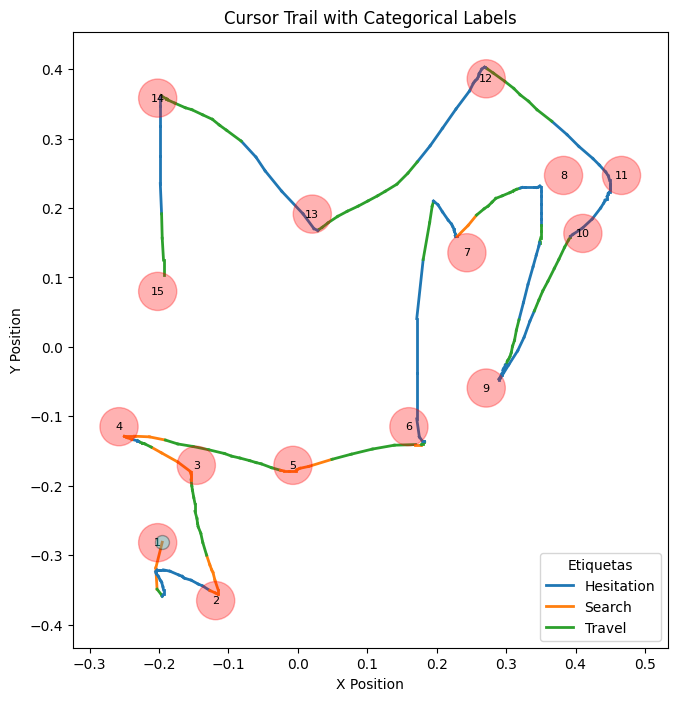

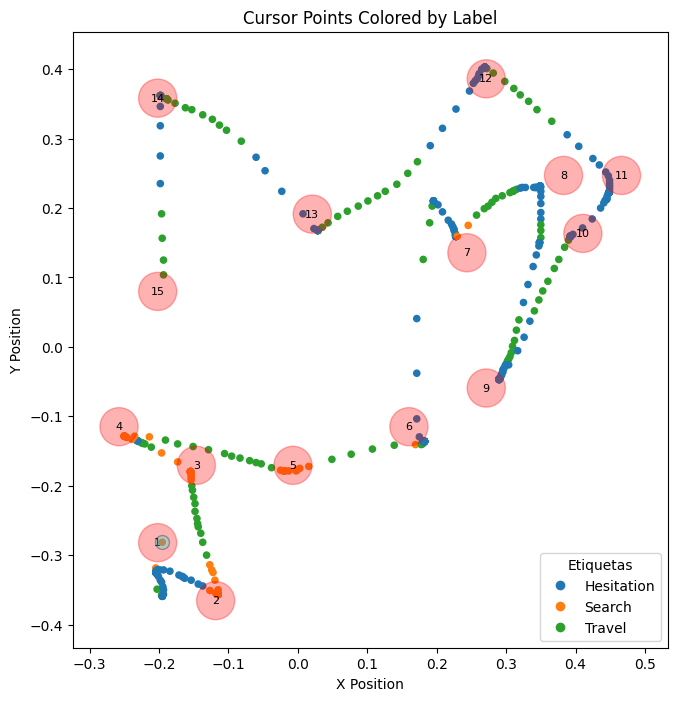

Trial ID: 12
Trial Type: TrialType.PART_B
Trial order: 3
Speed Threshold: 0.2043872724277266


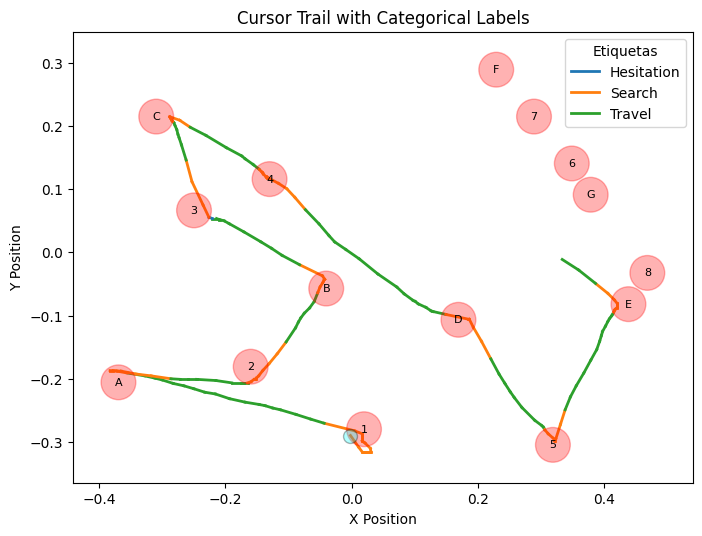

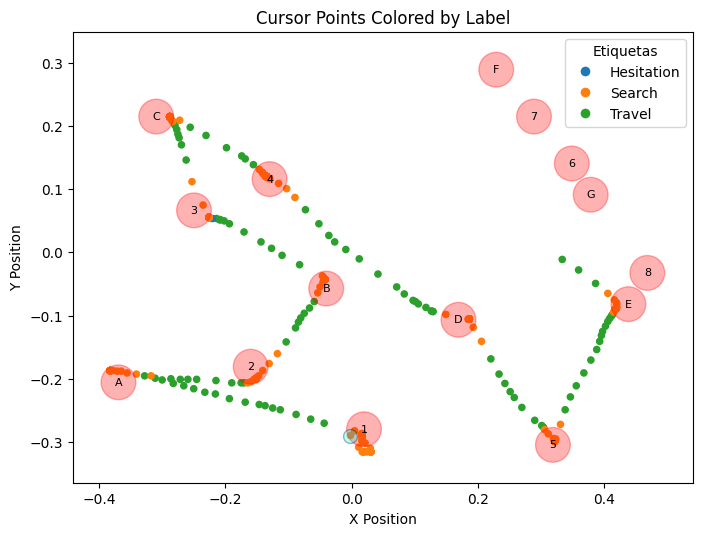

Trial ID: 1
Trial Type: TrialType.PART_A
Trial order: 4
Speed Threshold: 0.2043872724277266


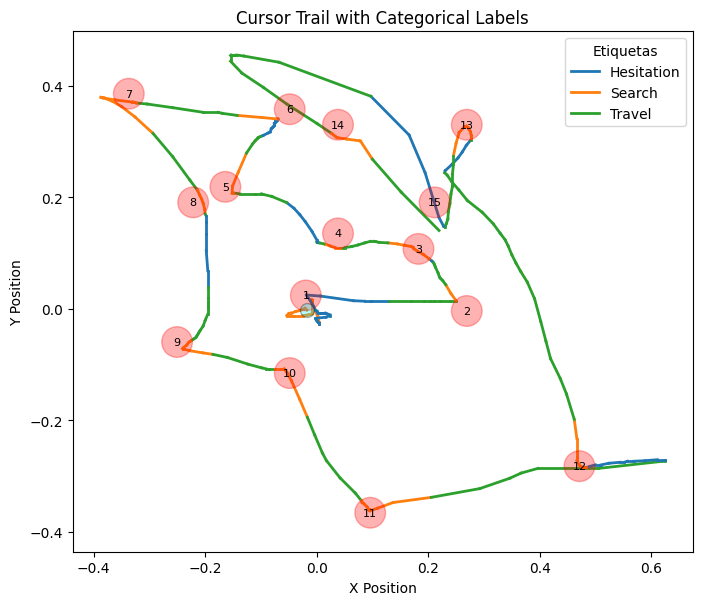

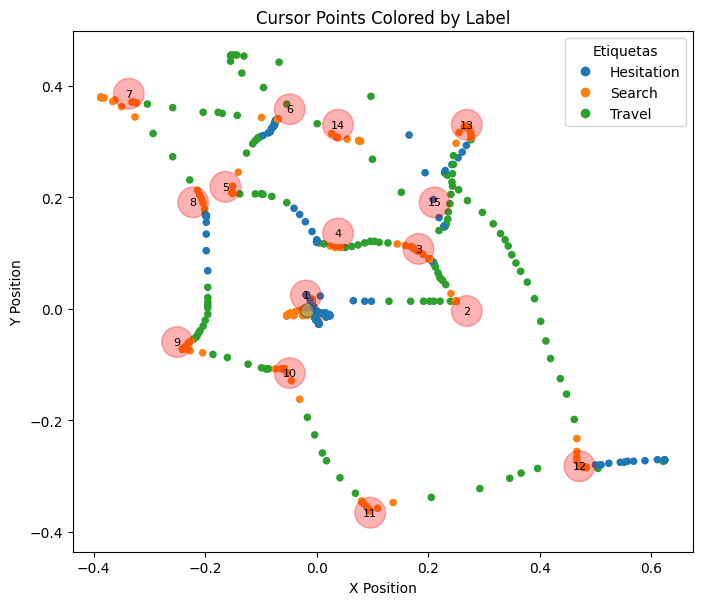

Trial ID: 20
Trial Type: TrialType.PART_B
Trial order: 5
Speed Threshold: 0.2043872724277266


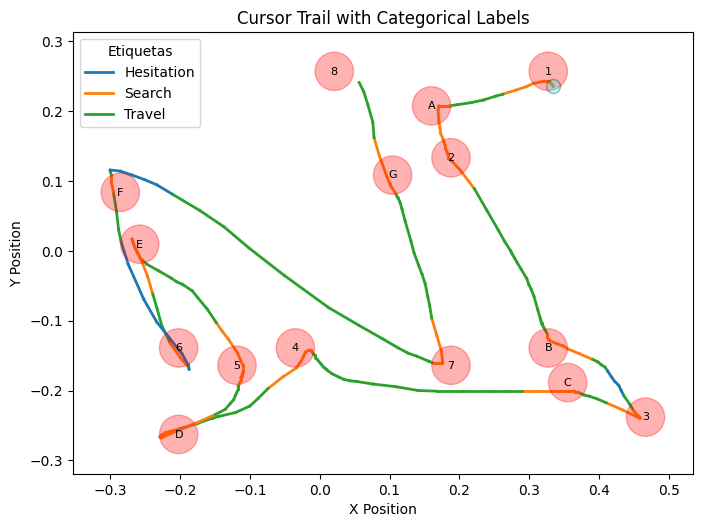

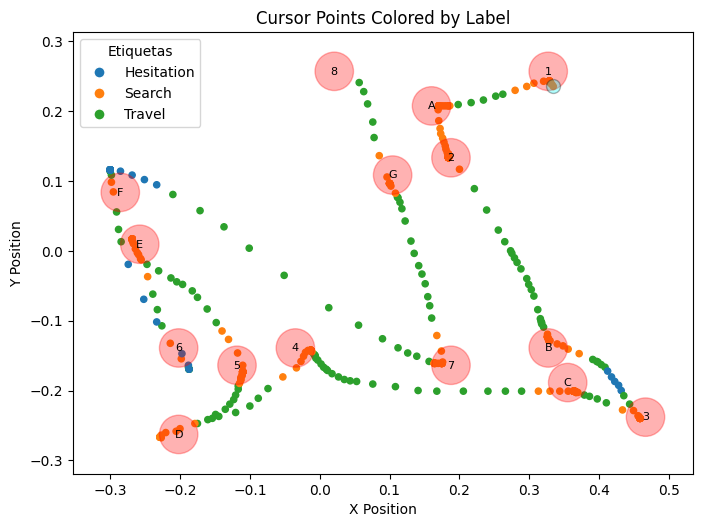

Trial ID: 11
Trial Type: TrialType.PART_A
Trial order: 6
Speed Threshold: 0.2043872724277266


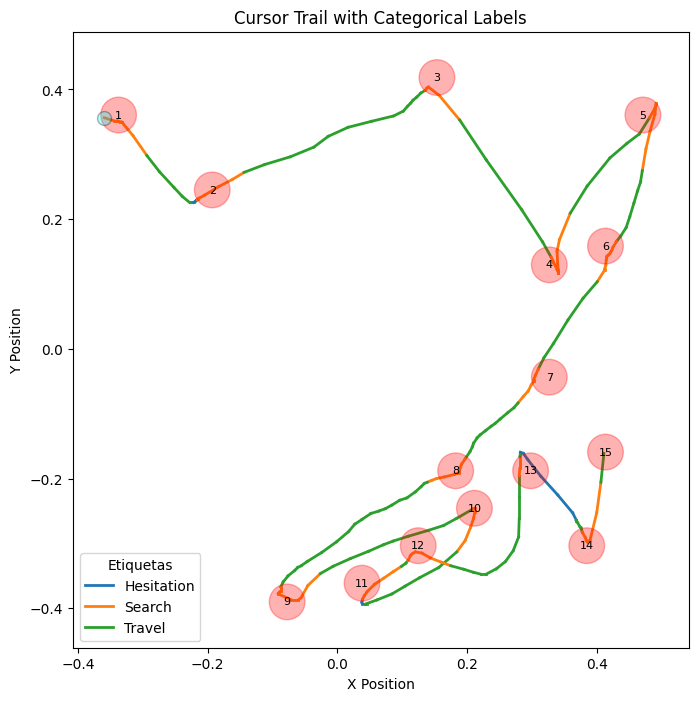

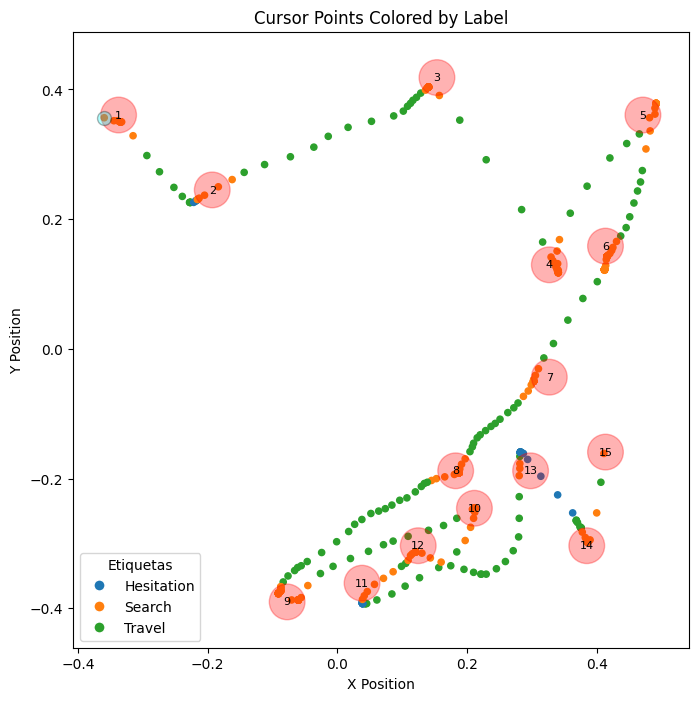

Trial ID: 13
Trial Type: TrialType.PART_B
Trial order: 7
Speed Threshold: 0.2043872724277266


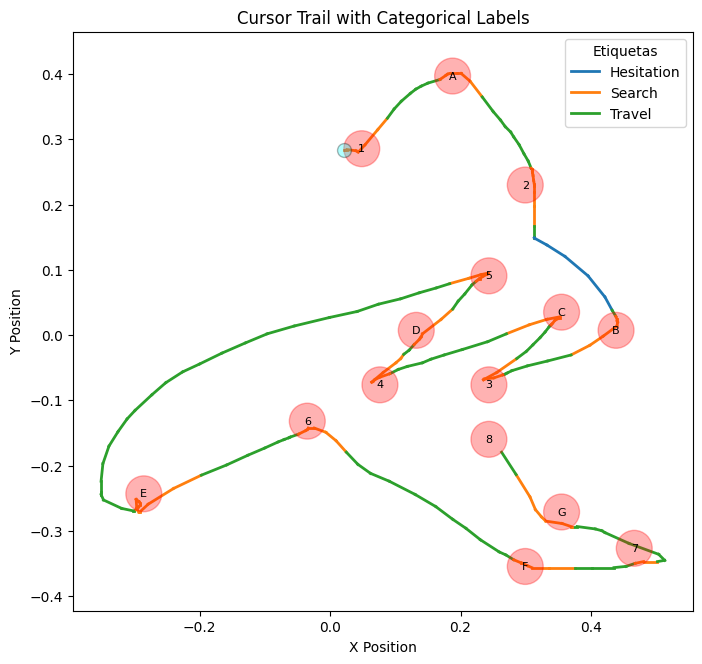

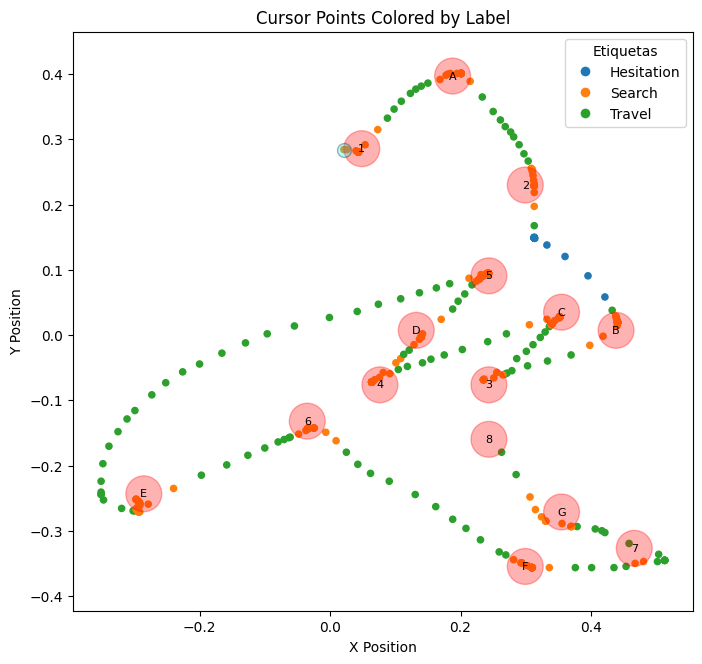

Trial ID: 17
Trial Type: TrialType.PART_A
Trial order: 8
Speed Threshold: 0.2043872724277266


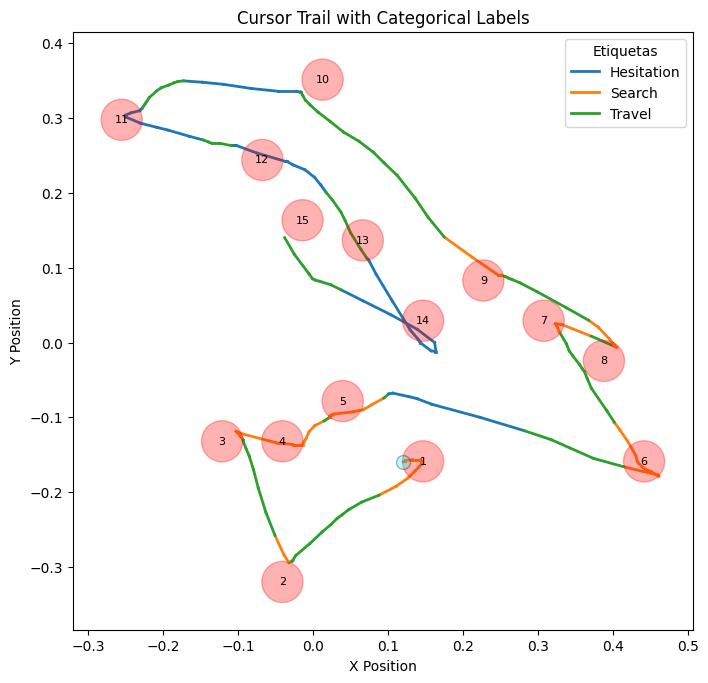

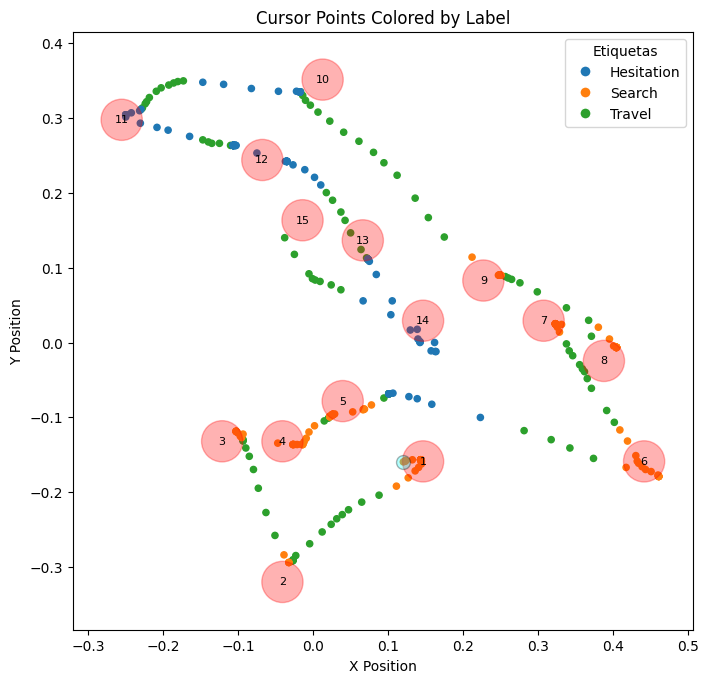

Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
Speed Threshold: 0.2043872724277266


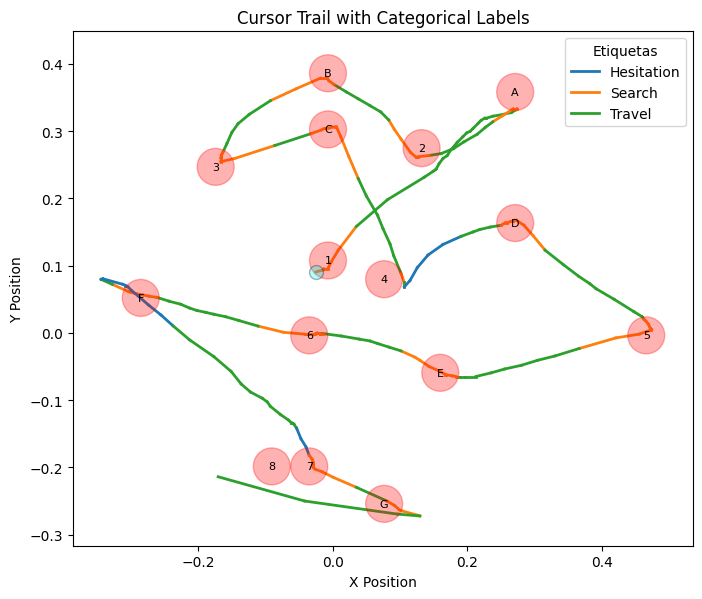

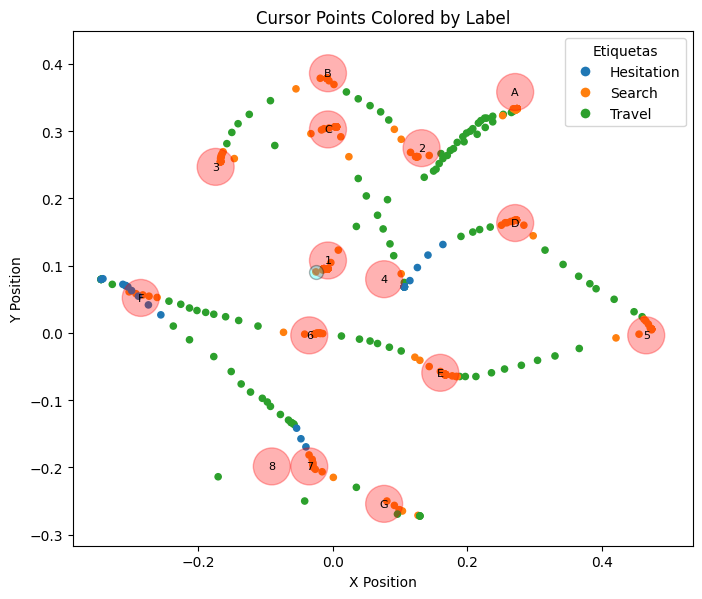

Trial ID: 5
Trial Type: TrialType.PART_A
Trial order: 10
Speed Threshold: 0.2043872724277266


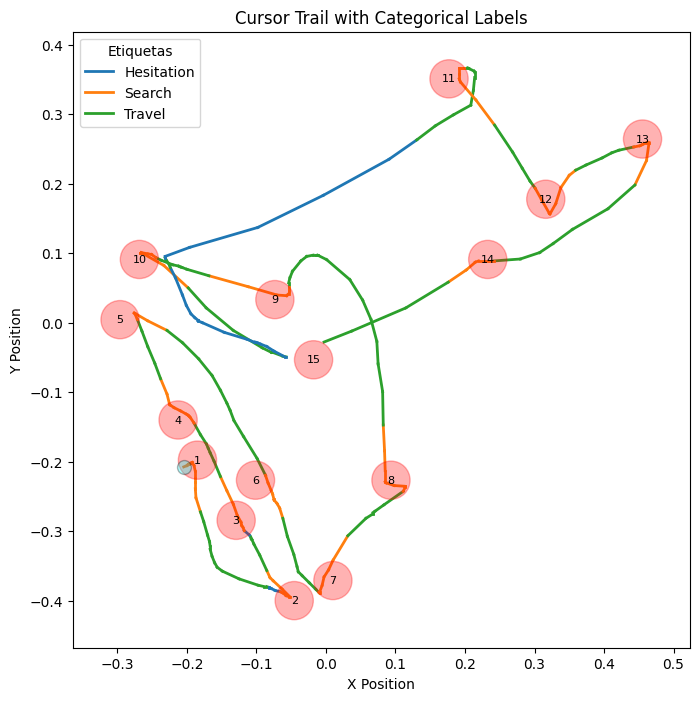

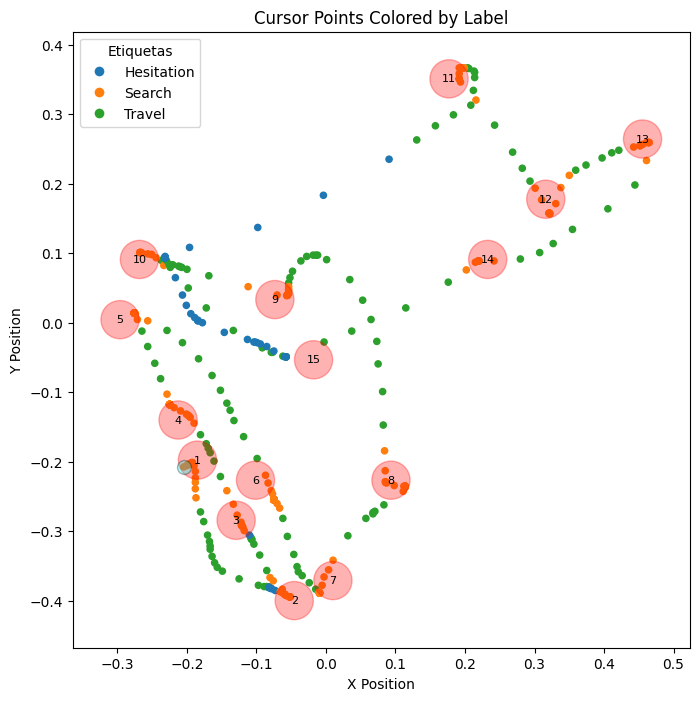

Trial ID: 10
Trial Type: TrialType.PART_B
Trial order: 11
Speed Threshold: 0.2043872724277266


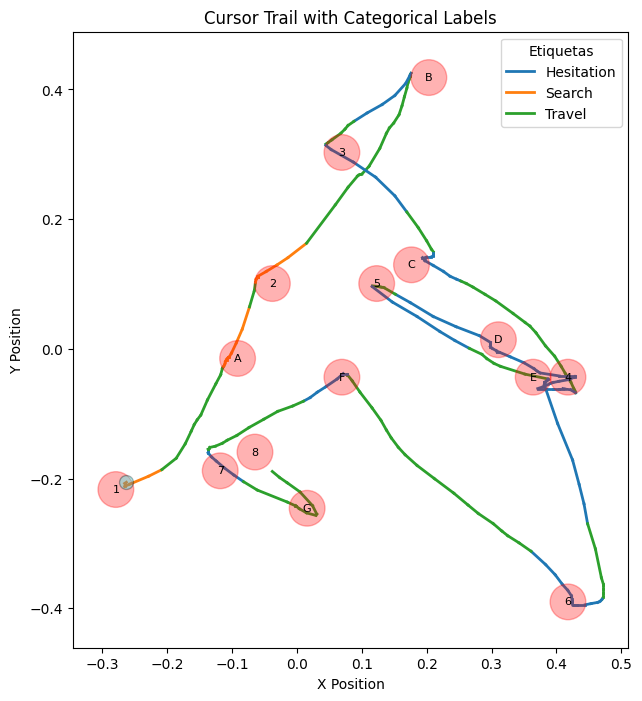

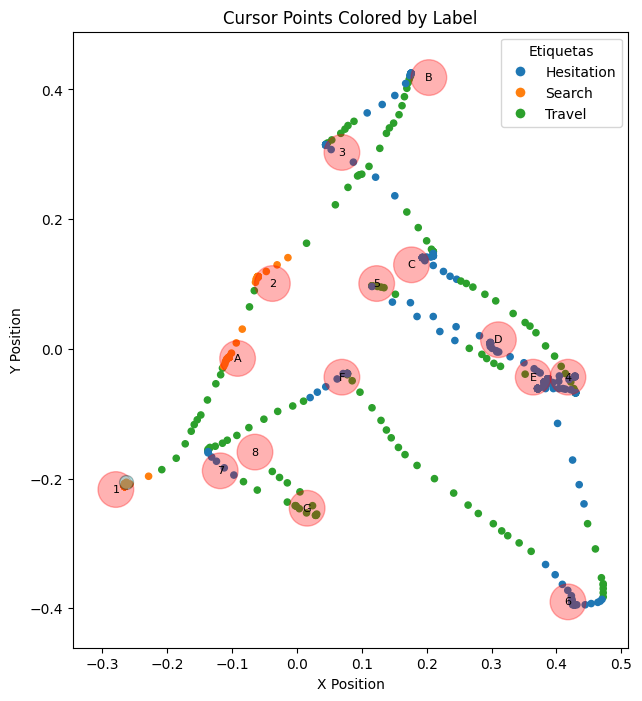

Trial ID: 9
Trial Type: TrialType.PART_A
Trial order: 12
Speed Threshold: 0.2043872724277266


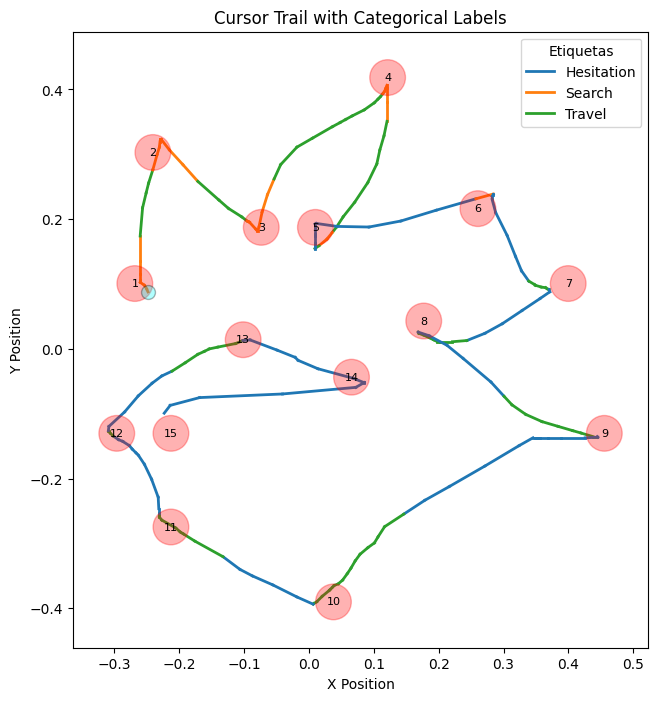

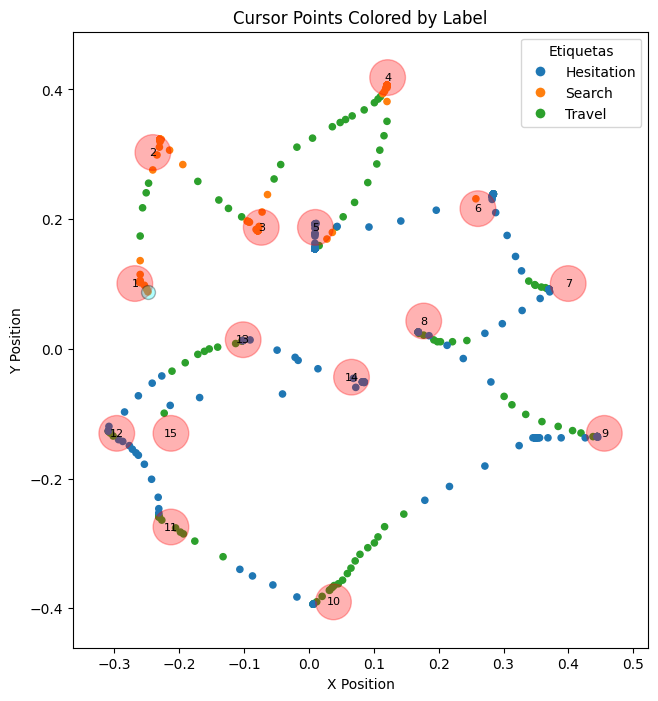

Trial ID: 16
Trial Type: TrialType.PART_B
Trial order: 13
Speed Threshold: 0.2043872724277266


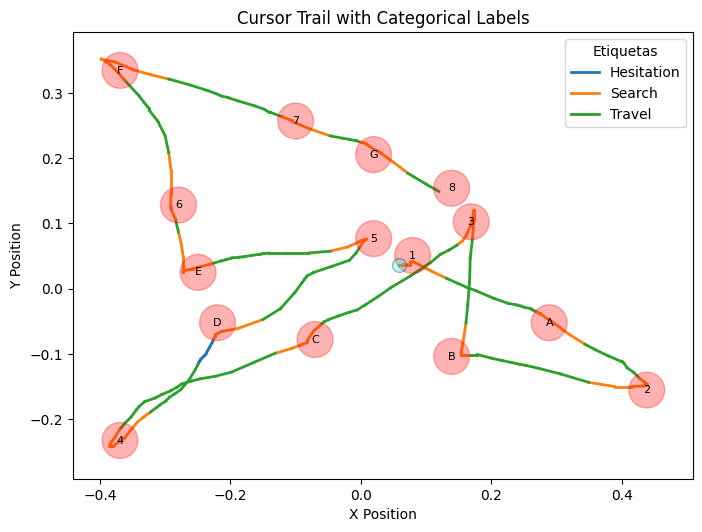

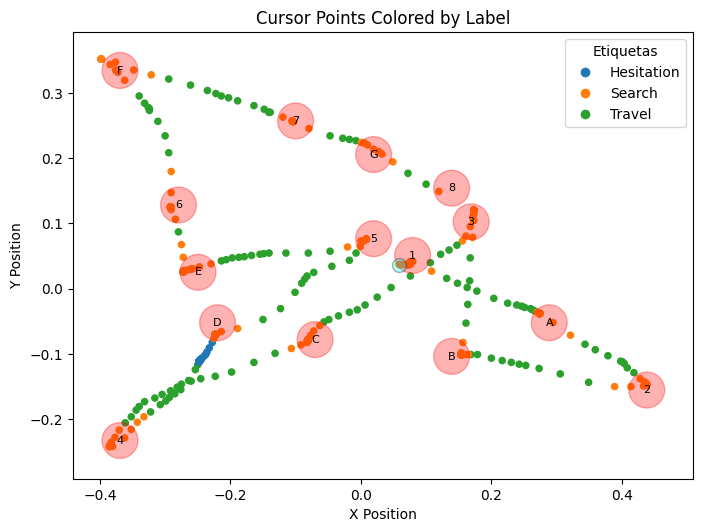

Trial ID: 15
Trial Type: TrialType.PART_A
Trial order: 14
Speed Threshold: 0.2043872724277266


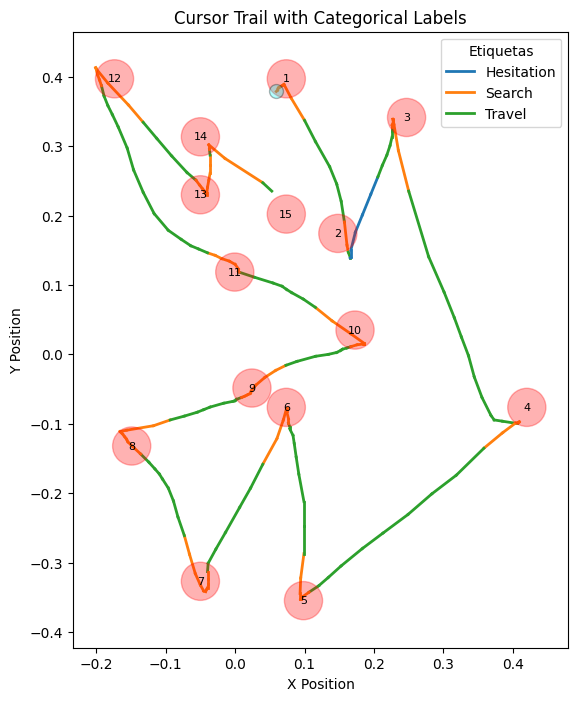

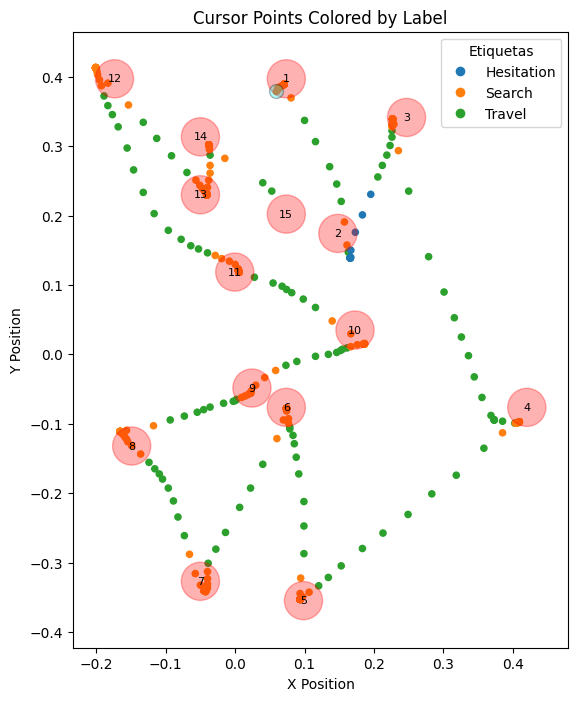

Trial ID: 2
Trial Type: TrialType.PART_B
Trial order: 15
Speed Threshold: 0.2043872724277266


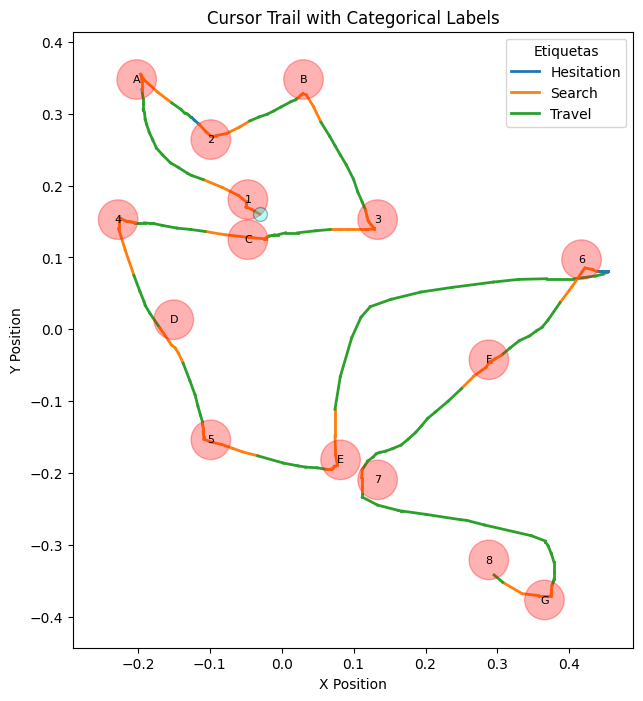

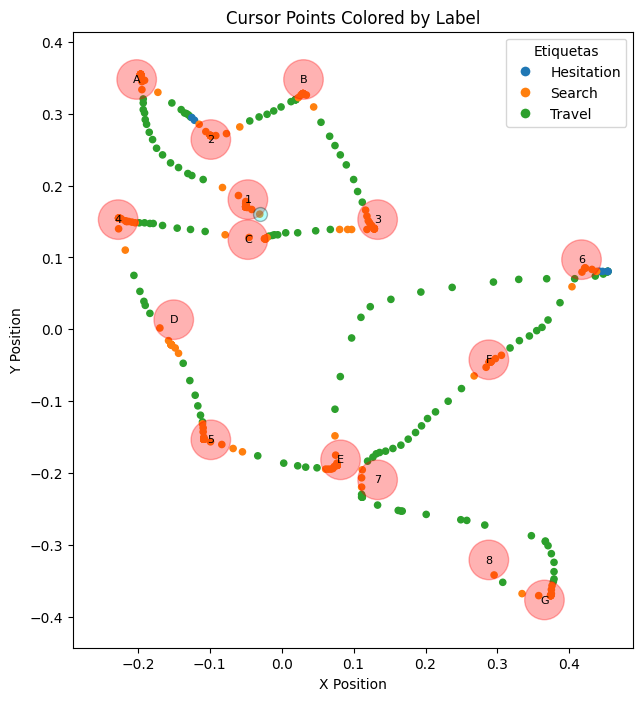

Trial ID: 3
Trial Type: TrialType.PART_A
Trial order: 16
Speed Threshold: 0.2043872724277266


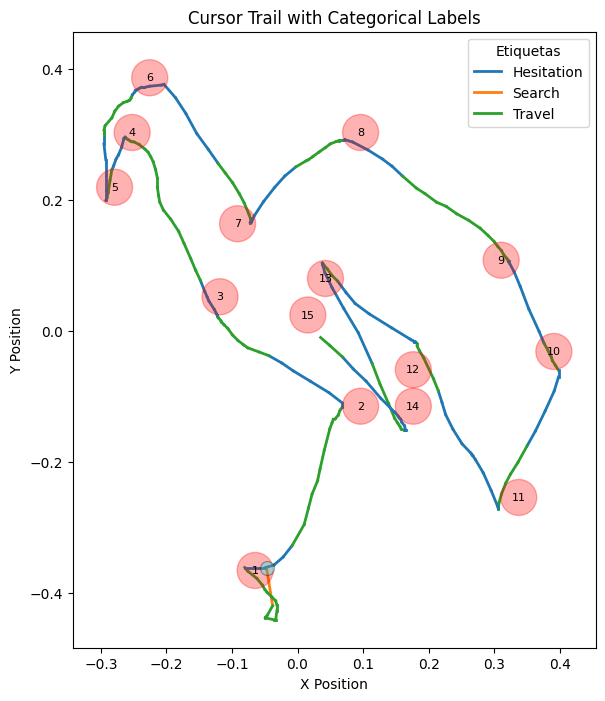

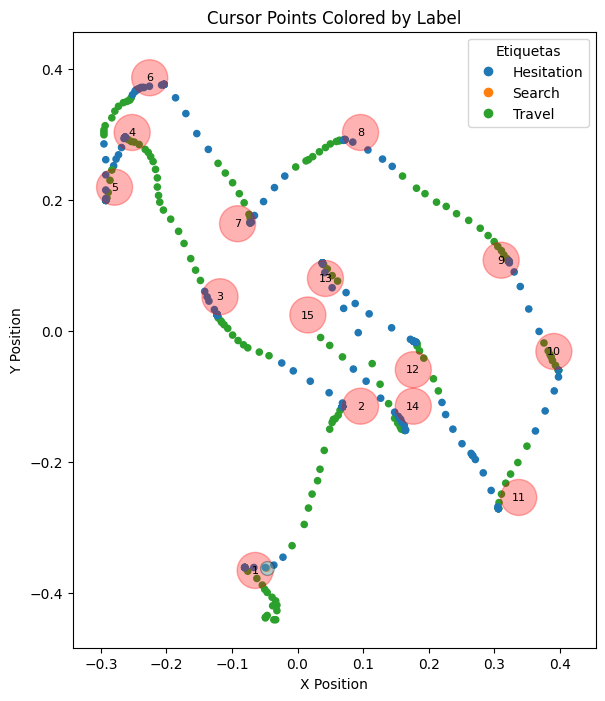

Trial ID: 8
Trial Type: TrialType.PART_B
Trial order: 17
Speed Threshold: 0.2043872724277266


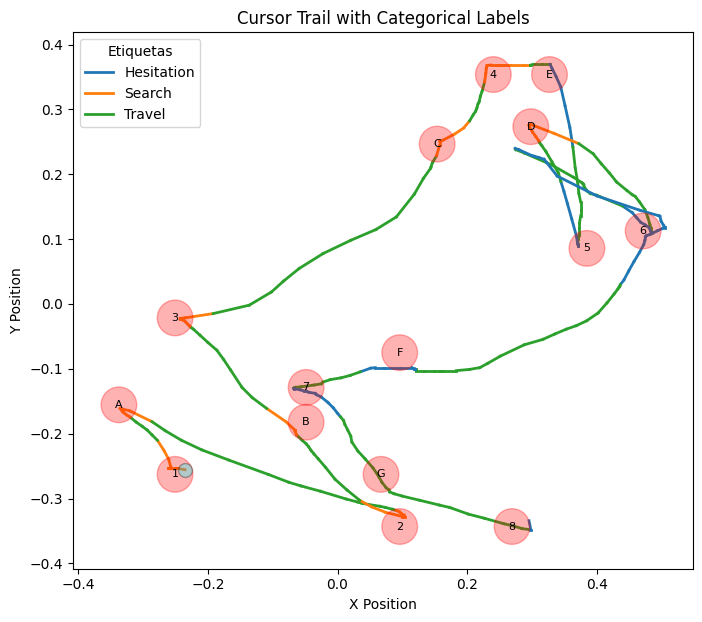

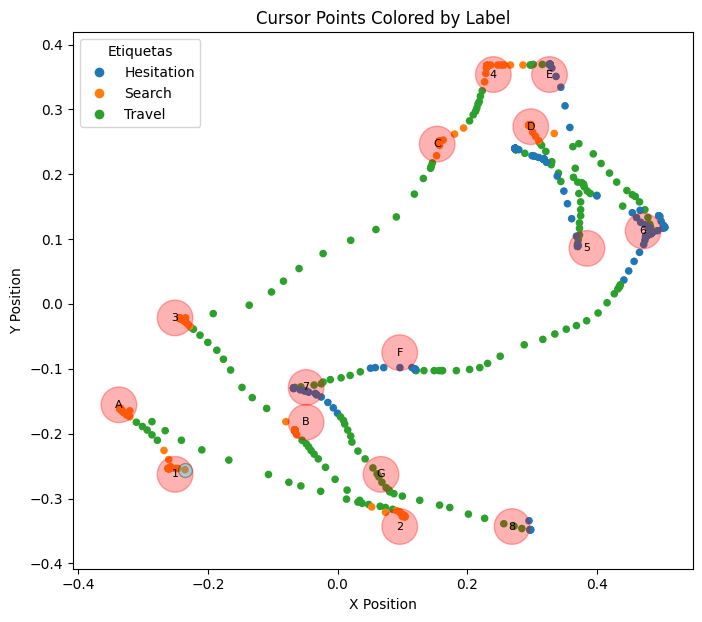

Trial ID: 6
Trial Type: TrialType.PART_A
Trial order: 18
Speed Threshold: 0.2043872724277266


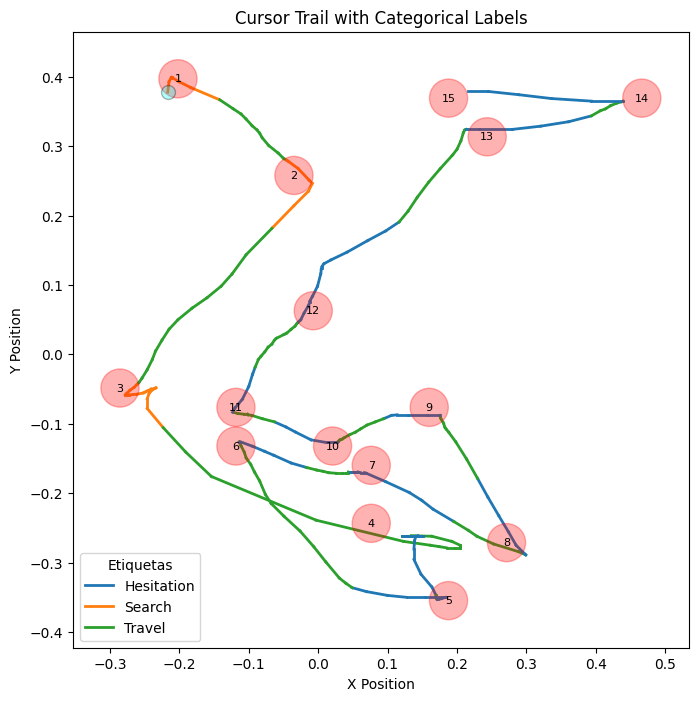

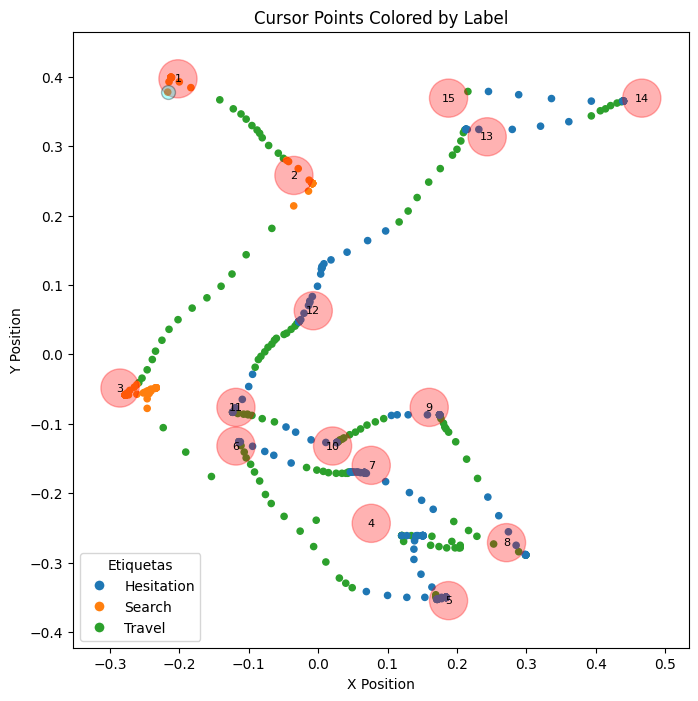

Trial ID: 4
Trial Type: TrialType.PART_B
Trial order: 19
Speed Threshold: 0.2043872724277266


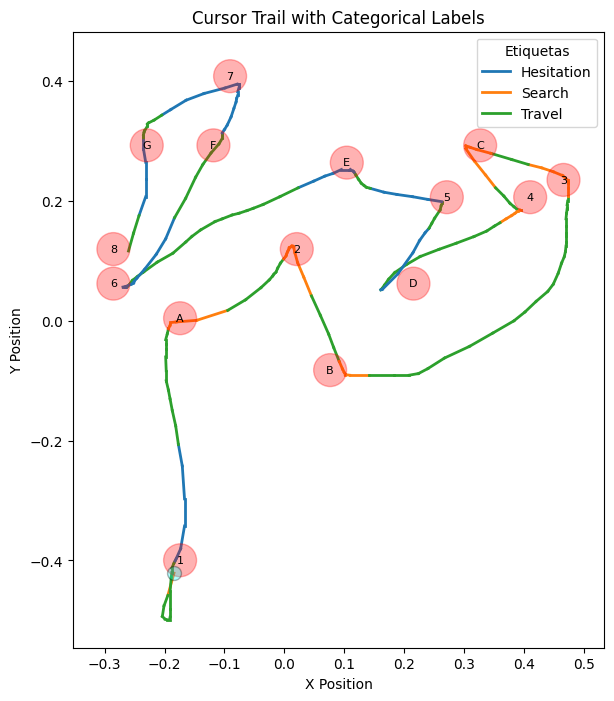

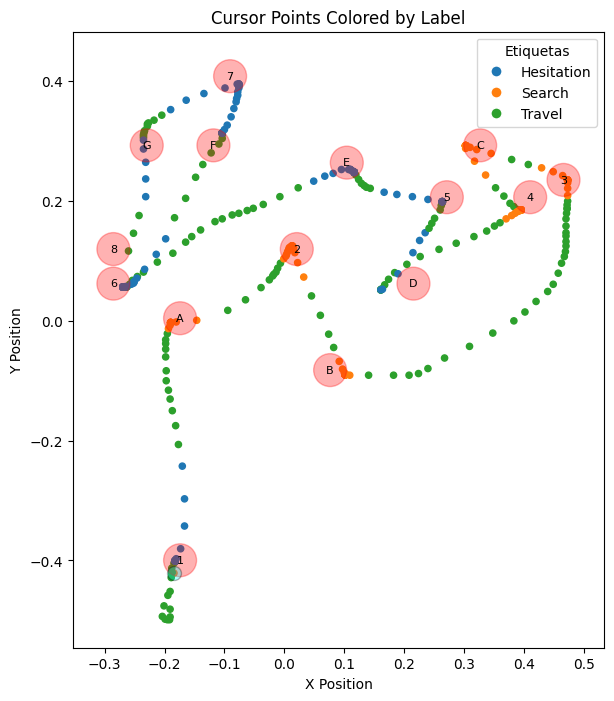

Trial ID: 19
Trial Type: TrialType.PART_A
Trial order: 20
Speed Threshold: 0.2043872724277266


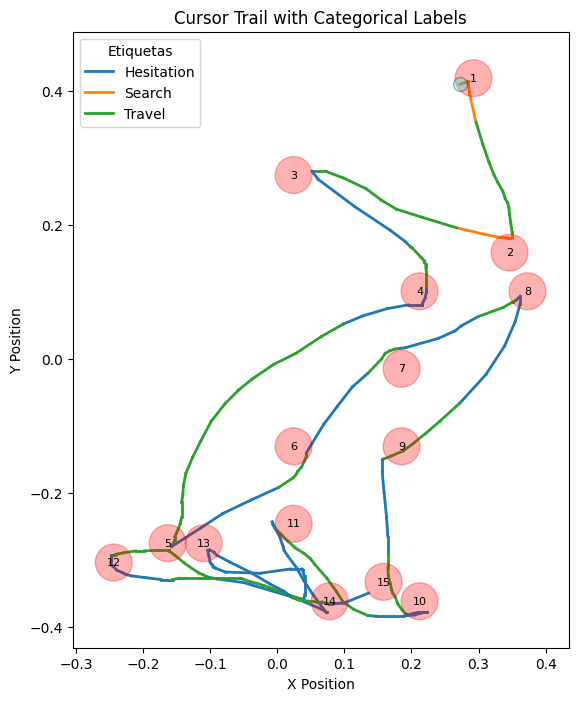

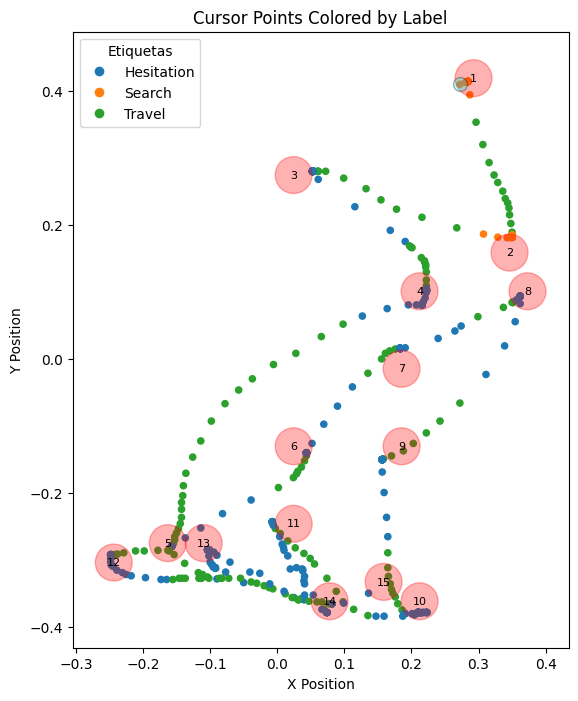

Trial ID: 21
Trial Type: TrialType.PART_B
Trial order: 21
Speed Threshold: 0.2043872724277266


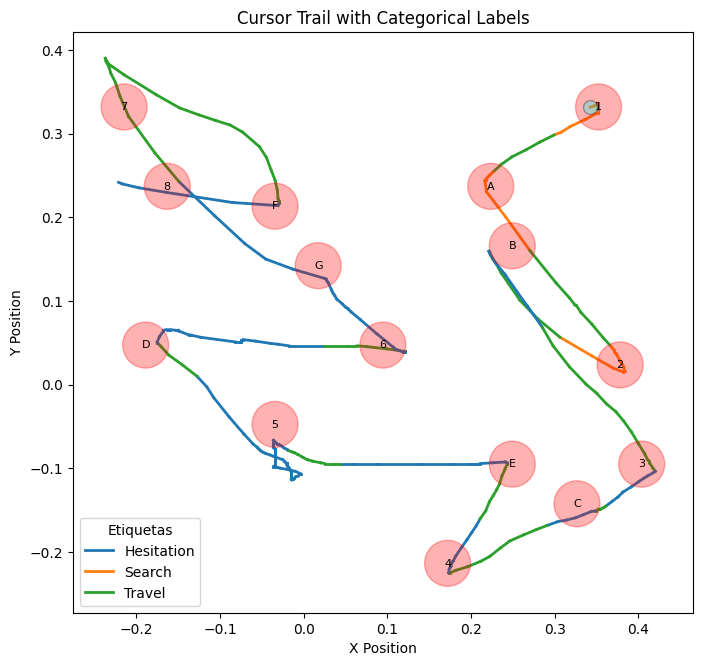

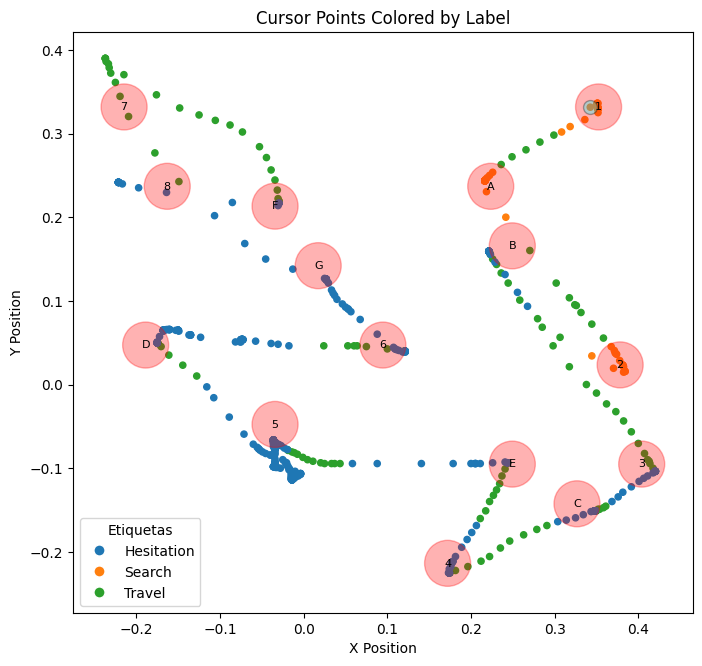

-----------------------------------------------



In [16]:
from neurotask.tmt.segmentation.segmentation import classify_cursor_positions_with_hesitation
from neurotask.tmt.metrics.targets_touched import *

for trial in subject.testing_trials:
    print("Trial ID:", trial.id)
    print("Trial Type:", trial.trial_type)
    print("Trial order:", trial.order_of_appearance)

    trial_analysis = subject_analysis[subject_analysis['trial_id'] == trial.id]
    speed_threshold = trial_analysis['speed_threshold'].values[0]
    print("Speed Threshold:", speed_threshold)
    segmentation: List[Tuple[str, CursorInfo]] = classify_cursor_positions_with_hesitation(trial,
                                                                                           subject.target_radius,
                                                                                           speed_threshold)
    segmentation_labels = [label for (label, color) in segmentation]

    plot_with_labels(trial, subject.target_radius, segmentation_labels)

    plot_with_labels_scatter(trial, subject.target_radius, segmentation_labels)

    plt.show()

print("-----------------------------------------------")
print("")